# Data Preparation

In [ ]:
import dowhy
from dowhy import CausalModel

import numpy as np
import pandas as pd
import graphviz
import networkx as nx


from causallearn.search.FCMBased import lingam
from causallearn.search.FCMBased.lingam.utils import make_dot
from dowhy import CausalModel
import dowhy.gcm as gcm


np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)


def make_graph(adjacency_matrix, labels=None):
    idx = np.abs(adjacency_matrix) > 0.01
    dirs = np.where(idx)
    d = graphviz.Digraph(engine="dot")
    names = labels if labels else [f"x{i}" for i in range(len(adjacency_matrix))]
    for name in names:
        d.node(name)
    for to, from_, coef in zip(dirs[0], dirs[1], adjacency_matrix[idx]):
        d.edge(names[from_], names[to], label=str(coef))
    return d


def str_to_dot(string):
    """
    Converts input string from graphviz library to valid DOT graph format.
    """
    graph = string.strip().replace("\n", ";").replace("\t", "")
    graph = (
        graph[:9] + graph[10:-2] + graph[-1]
    )  # Removing unnecessary characters from string
    return graph


data_df = pd.read_csv(
    "/Users/lujun.li/projects/causallm-github/causalllm/resource/output/MT/exp_result_Meta-Llama-3-8B-Instruct_sp_bleu.csv"
)


data_df.dropna(inplace=True)
# data_df = data_df[["Temperature", "model", "elapsed_time", "spbleu", "dataset_name"]]
data_df = data_df[["Temperature", "elapsed_time", "spbleu", "dataset_name", "model"]]
print(data_df.shape)


def string_encode(data):
    unique_strings = data.unique()
    string_map = {string: i for i, string in enumerate(unique_strings)}
    encoded_data = data.map(string_map)
    return encoded_data


encoded_dataset_name = string_encode(data_df["dataset_name"])
data_df["dataset_encoded"] = encoded_dataset_name

data_df.head()


import networkx as nx
import matplotlib.pyplot as plt

# Data Based GCM Modeling Graph Causal Model

(2100, 5)


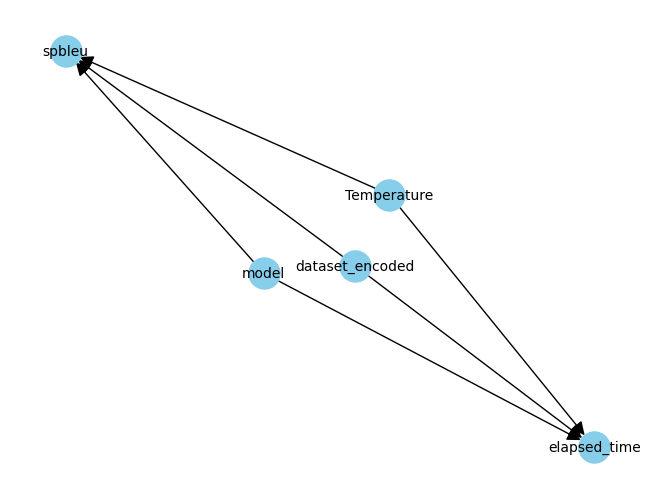

In [86]:
# Add prior knowledge
causal_graph = nx.DiGraph(
    [
        ("Temperature", "elapsed_time"),
        ("Temperature", "spbleu"),
        ("Temperature", "elapsed_time"),
        ("model", "spbleu"),
        ("model", "elapsed_time"),
        ("dataset_encoded", "elapsed_time"),
        ("dataset_encoded", "spbleu"),
    ]
)
pos = nx.spring_layout(causal_graph)
nx.draw(
    causal_graph,
    pos,
    with_labels=True,
    node_color="skyblue",
    node_size=500,
    font_size=10,
    arrowsize=20,
)
plt.show()

See the data

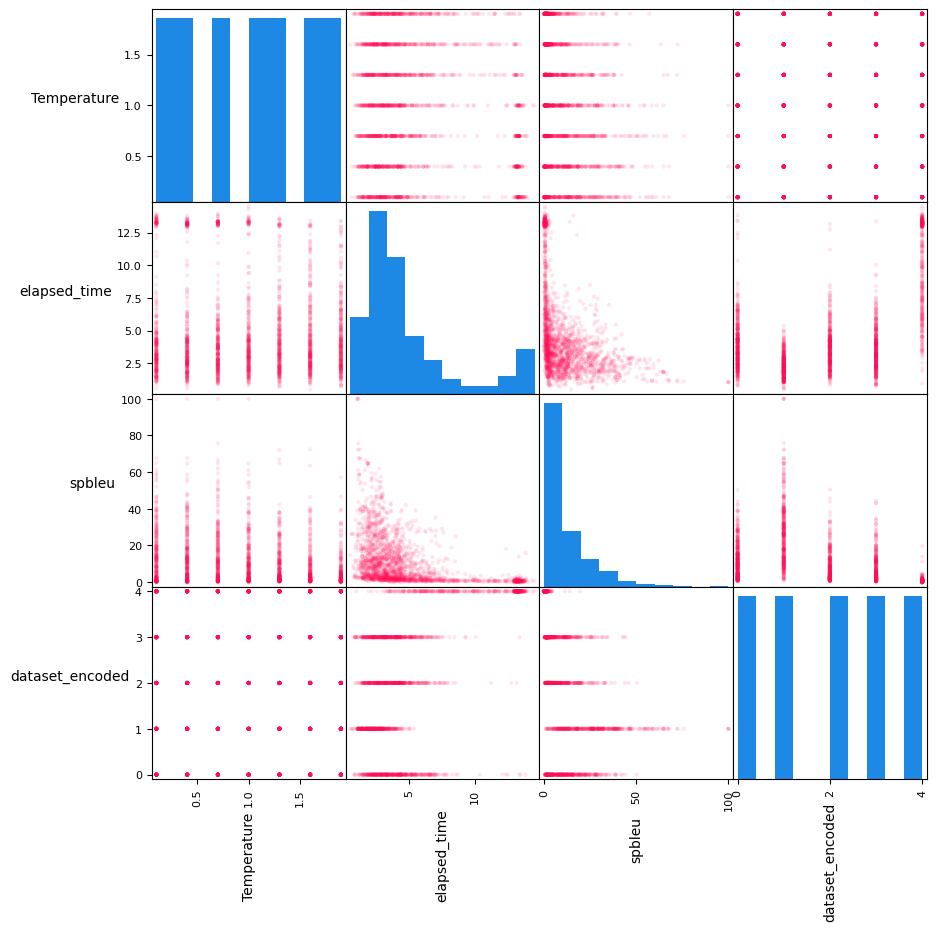

In [2]:
axes = pd.plotting.scatter_matrix(
    data_df, figsize=(10, 10), c="#ff0d57", alpha=0.1, hist_kwds={"color": ["#1E88E5"]}
)
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha("right")

In [2]:
causal_graph = nx.DiGraph(
    [
        ("Temperature", "elapsed_time"),
        ("Temperature", "spbleu"),
        ("Temperature", "elapsed_time"),
        ("model", "spbleu"),
        ("model", "elapsed_time"),
        ("dataset_encoded", "elapsed_time"),
        ("dataset_encoded", "spbleu"),
    ]
)

causal_model = gcm.StructuralCausalModel(
    causal_graph
)  # Automatic set the causal effect

quality = gcm.auto.AssignmentQuality.BEST
summary_auto_assignment = gcm.auto.assign_causal_mechanisms(
    causal_model, data_df, quality=quality
)
print(summary_auto_assignment)

gcm.fit(causal_model, data_df)

When using this auto assignment function, the given data is used to automatically assign a causal mechanism to each node. Note that causal mechanisms can also be customized and assigned manually.
The following types of causal mechanisms are considered for the automatic selection:

If root node:
An empirical distribution, i.e., the distribution is represented by randomly sampling from the provided data. This provides a flexible and non-parametric way to model the marginal distribution and is valid for all types of data modalities.

If non-root node and the data is continuous:
Additive Noise Models (ANM) of the form X_i = f(PA_i) + N_i, where PA_i are the parents of X_i and the unobserved noise N_i is assumed to be independent of PA_i.To select the best model for f, different regression models are evaluated and the model with the smallest mean squared error is selected.Note that minimizing the mean squared error here is equivalent to selecting the best choice of an ANM.

If non-root node

Fitting causal mechanism of node dataset_name: 100%|██████████| 5/5 [00:25<00:00,  5.11s/it]


In [11]:
causal_model.causal_mechanism("Temperature")
for node in causal_model.graph.nodes:
    print(f"Node: {node}   {causal_model.causal_mechanism(node)}")

Node: Temperature   Empirical Distribution
Node: elapsed_time   AdditiveNoiseModel using AutoGluonRegressor
Node: spbleu   AdditiveNoiseModel using AutoGluonRegressor
Node: model   Empirical Distribution
Node: dataset_name   Empirical Distribution


In [13]:
data_df_validation = pd.read_csv(
    "/Users/lujun.li/projects/causallm-github/causalllm/resource/output/MT/exp_result_Llama-2-70b-chat-hf_sp_bleu.csv"
)
data_df.dropna(inplace=True)
# data_df = data_df[["Temperature", "model", "elapsed_time", "spbleu", "dataset_name"]]
data_df_validation = data_df_validation[
    ["Temperature", "elapsed_time", "spbleu", "dataset_name", "model"]
]
print(data_df_validation.shape)
data_df_validation.head()

(2100, 5)


,Temperature,elapsed_time,spbleu,dataset_name,model
0,0.1,19.251106,2.692794,mlt_Latn,Llama-2-70b-chat-hf
1,0.1,13.183325,19.193097,mlt_Latn,Llama-2-70b-chat-hf
2,0.1,10.344519,3.268069,mlt_Latn,Llama-2-70b-chat-hf
3,0.1,15.676424,12.334265,mlt_Latn,Llama-2-70b-chat-hf
4,0.1,11.430753,2.051245,mlt_Latn,Llama-2-70b-chat-hf


Evaluating causal mechanisms...: 100%|██████████| 5/5 [00:00<00:00, 3689.57it/s]
/opt/anaconda3/envs/causalAnalysis/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/causalAnalysis/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/causalAnalysis/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/causalAnalysis/lib/python3.9/site-packages/sklearn

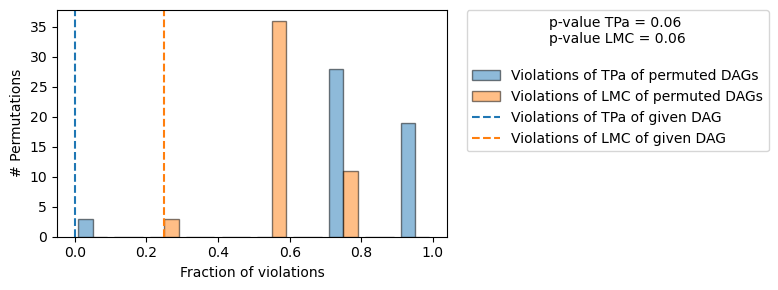

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [15]:
summary_evaluation = gcm.evaluate_causal_model(
    causal_model, data_df, compare_mechanism_baselines=True
)
print(summary_evaluation)

# Causal Model Using dowhy without gcm

Graphical Causal Models in Dowhy:

1. We have causal bayesian Network

2. We also have Functional Causal Model


Quantify causal effect, Counterfactural analysis

GCM you have a causal mechanism and this is a good API and then use this gcm api to all the causal query.

gcm. interventation, attribute_anaomalie 

But it's experimemtal !!!

Let's try without gcm !!!! 

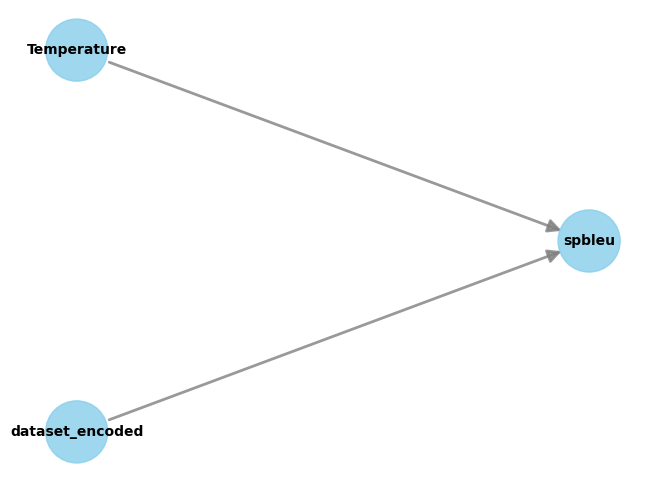

In [ ]:
model = CausalModel(
    data=data_df,
    treatment=["Temperature"],
    outcome=["spbleu"],
    effect_modifiers=["dataset_encoded"],
)
model.view_model()

In [ ]:
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                  
──────────────(E[spbleu])
d[Temperature]           
Estimand assumption 1, Unconfoundedness: If U→{Temperature} and U→spbleu then P(spbleu|Temperature,,U) = P(spbleu|Temperature,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [99]:
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression",
    control_value=0,
    treatment_value=1,
)

# IV. Refute the obtained estimate using multiple robustness checks.
refute_results = model.refute_estimate(
    identified_estimand, estimate, method_name="random_common_cause"
)
print(refute_results)

Refute: Add a random common cause
Estimated effect:-5.470102762405487
New effect:-5.469561209370386
p value:0.94



Test permutations of given graph: 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]


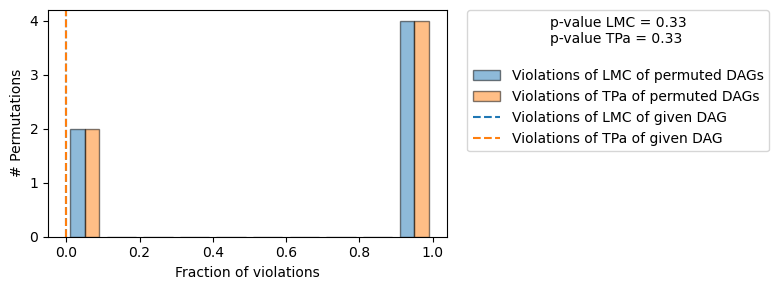

+-------------------------------------------------------------------------------------------------------+
|                                         Falsificaton Summary                                          |
+-------------------------------------------------------------------------------------------------------+
| The given DAG is not informative because 2 / 6 of the permutations lie in the Markov                  |
| equivalence class of the given DAG (p-value: 0.33).                                                   |
| The given DAG violates 0/2 LMCs and is better than 66.7% of the permuted DAGs (p-value: 0.33).        |
| Based on the provided significance level (0.05) and because the DAG is not informative,               |
| we do not reject the DAG.                                                                             |
+-------------------------------------------------------------------------------------------------------+


In [110]:
# Import the necessary libraries and functions for this demo
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.ensemble import GradientBoostingRegressor
from dowhy.gcm.falsify import (
    FalsifyConst,
    falsify_graph,
    plot_local_insights,
    run_validations,
    apply_suggestions,
)
from dowhy.gcm.independence_test.generalised_cov_measure import generalised_cov_based
from dowhy.gcm.util import plot
from dowhy.gcm.util.general import set_random_seed
from dowhy.gcm.ml import SklearnRegressionModel

# Set random seed
set_random_seed(1332)

# Run evaluation and plot the result using `plot=True`
result = falsify_graph(
    causal_graph=model._graph._graph,
    data=data_df,
    plot_histogram=True,
    n_permutations=1000,
)
# Summarize the result
print(result)

Only effect estimation

In [114]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor

start = 0
end = 2
num_points = 20
step = (end - start) / num_points
points = np.arange(start, end, step)

results_df = pd.DataFrame(
    columns=[
        "dataset_encoded",
        "control_value",
        "treatement_value",
        "estimation_interpretation",
        "estimation_params",
        "estimation_effect",
    ]
)

for dataset_encoded in range(5):
    for point in points:
        dml_estimate = model.estimate_effect(
            identified_estimand,
            method_name="backdoor.econml.dml.DML",
            control_value=point,
            treatment_value=point + step,
            target_units=lambda df: df["dataset_encoded"] == dataset_encoded,
            confidence_intervals=False,
            # evaluate_effect_strength=True,
            method_params={
                "init_params": {
                    "model_y": GradientBoostingRegressor(),
                    "model_t": GradientBoostingRegressor(),
                    "model_final": LassoCV(fit_intercept=False),
                    "featurizer": PolynomialFeatures(degree=1, include_bias=False),
                },
                "fit_params": {},
            },
        )

        new_data = {
            "dataset_encoded": dataset_encoded,
            "control_value": point,
            "treatement_value": point + step,
            "estimation_interpretation": dml_estimate.interpret().__str__(),
            "estimation_params": [dml_estimate.params],
            "estimation_effect": [dml_estimate.value],
        }

        new_data_df = pd.DataFrame(new_data)
        results_df = pd.concat([results_df, new_data_df], ignore_index=True)
        print(len(results_df))

Increasing the treatment variable(s) [Temperature] from 0.0 to [0.1] causes an increase of -0.8985944782182482 in the expected value of the outcome [['spbleu']], over the data distribution/population represented by the dataset.
1
Increasing the treatment variable(s) [Temperature] from 0.1 to [0.2] causes an increase of -0.9168601609097938 in the expected value of the outcome [['spbleu']], over the data distribution/population represented by the dataset.
2
Increasing the treatment variable(s) [Temperature] from 0.2 to [0.30000000000000004] causes an increase of -0.9138661359439785 in the expected value of the outcome [['spbleu']], over the data distribution/population represented by the dataset.
3
Increasing the treatment variable(s) [Temperature] from 0.30000000000000004 to [0.4] causes an increase of -0.9169669362816281 in the expected value of the outcome [['spbleu']], over the data distribution/population represented by the dataset.
4
Increasing the treatment variable(s) [Temperatur

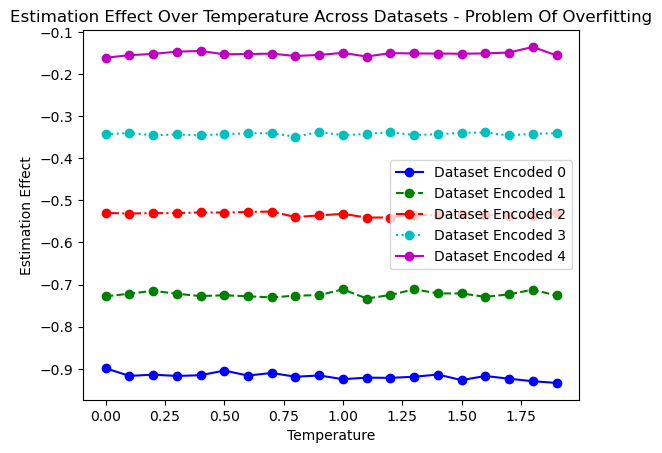

In [116]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

grouped = results_df.groupby("dataset_encoded")

colors = ["b", "g", "r", "c", "m", "y", "k"]
linestyles = ["-", "--", "-.", ":"]

for i, (name, group) in enumerate(grouped):
    color = colors[i % len(colors)]
    linestyle = linestyles[i % len(linestyles)]
    ax.plot(
        group["control_value"],
        group["estimation_effect"],
        marker="o",
        linestyle=linestyle,
        label=f"Dataset Encoded {name}",
        color=color,
    )

plt.title("Estimation Effect Over Temperature Across Datasets - Problem Of Overfitting")
plt.xlabel("Temperature")
plt.ylabel("Estimation Effect")
plt.legend()
plt.show()

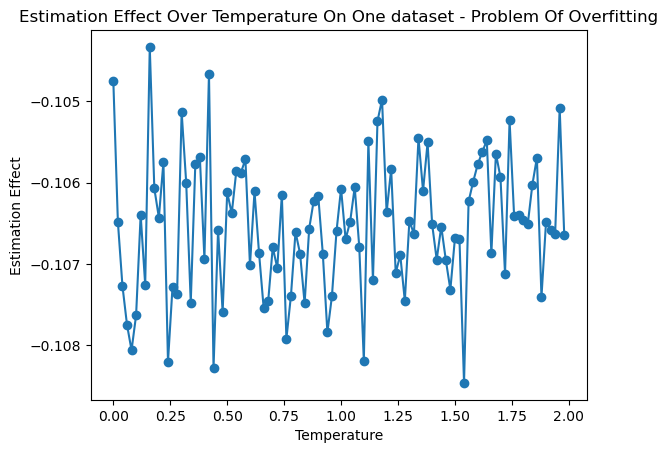

In [ ]:
import matplotlib.pyplot as plt

plt.plot(
    results_df["control_value"],
    results_df["estimation_effect"],
    marker="o",
    linestyle="-",
)

plt.title("Estimation Effect Over Temperature On One dataset - Problem Of Overfitting")
plt.xlabel("Temperature")
plt.ylabel("Estimation Effect")
plt.show()

Effect estimation + Refutation

In [ ]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor

start = 0
end = 2
num_points = 20
step = (end - start) / num_points
points = np.arange(start, end, step)

results_df = pd.DataFrame(
    columns=[
        "control_value",
        "treatement_value",
        "estimation_interpretation",
        "estimation_params",
        "estimation_effect",
        "res_random_refutation_results",
        "res_random_refutation_new_effect",
        "res_random_refutation_estimated_effect",
        "placbo_refutation_results",
        "placbo_refutation_new_effect",
        "placbo_refutation_estimated_effect",
    ]
)

for point in points:
    dml_estimate = model.estimate_effect(
        identified_estimand,
        method_name="backdoor.econml.dml.DML",
        control_value=point,
        treatment_value=point + step,
        confidence_intervals=False,
        # evaluate_effect_strength=True,
        method_params={
            "init_params": {
                "model_y": GradientBoostingRegressor(),
                "model_t": GradientBoostingRegressor(),
                "model_final": LassoCV(fit_intercept=False),
                "featurizer": PolynomialFeatures(degree=1, include_bias=False),
            },
            "fit_params": {},
        },
    )

    res_random = model.refute_estimate(
        identified_estimand,
        dml_estimate,
        method_name="random_common_cause",
    )

    res_placebo = model.refute_estimate(
        identified_estimand,
        dml_estimate,
        method_name="placebo_treatment_refuter",
        show_progress_bar=True,
    )

    # results_df = results_df.append(
    #     {
    #         "estimation_interpretation": dml_estimate.interpret(),
    #         "estimation_params": dml_estimate.params,
    #         "estimation_effect": dml_estimate.value,
    #         "res_random_refutation_results": res_random.refutation_result,
    #         "res_random_refutation_new_effect": res_random.new_effect,
    #         "res_random_refutation_estimated_effect": res_random.estimated_effect,
    #         "placbo_refutation_results": res_placebo.refutation_result,
    #         "placbo_refutation_new_effect": res_placebo.new_effect,
    #         "placbo_refutation_estimated_effect": res_placebo.estimated_effect,
    #     },
    #     ignore_index=True,
    # )

    new_data = {
        "control_value": point,
        "treatement_value": point + step,
        "estimation_interpretation": dml_estimate.interpret().__str__(),
        "estimation_params": [dml_estimate.params],
        "estimation_effect": [dml_estimate.value],
        "res_random_refutation_results": [res_random.refutation_result],
        "res_random_refutation_new_effect": [res_random.new_effect],
        "res_random_refutation_estimated_effect": [res_random.estimated_effect],
        "placbo_refutation_results": [res_placebo.refutation_result],
        "placbo_refutation_new_effect": [res_placebo.new_effect],
        "placbo_refutation_estimated_effect": [res_placebo.estimated_effect],
    }

    new_data_df = pd.DataFrame(new_data)
    results_df = pd.concat([results_df, new_data_df], ignore_index=True)
    print(len(results_df))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Increasing the treatment variable(s) [Temperature] from 0.0 to [0.1] causes an increase of -0.531124016904316 in the expected value of the outcome [['spbleu']], over the data distribution/population represented by the dataset.
1


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Increasing the treatment variable(s) [Temperature] from 0.1 to [0.2] causes an increase of -0.5403694259516022 in the expected value of the outcome [['spbleu']], over the data distribution/population represented by the dataset.
2


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Increasing the treatment variable(s) [Temperature] from 0.2 to [0.30000000000000004] causes an increase of -0.5376812641035948 in the expected value of the outcome [['spbleu']], over the data distribution/population represented by the dataset.
3


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Increasing the treatment variable(s) [Temperature] from 0.30000000000000004 to [0.4] causes an increase of -0.5421741563878909 in the expected value of the outcome [['spbleu']], over the data distribution/population represented by the dataset.
4


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Increasing the treatment variable(s) [Temperature] from 0.4 to [0.5] causes an increase of -0.5347837151127585 in the expected value of the outcome [['spbleu']], over the data distribution/population represented by the dataset.
5


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Increasing the treatment variable(s) [Temperature] from 0.5 to [0.6] causes an increase of -0.5464363216046043 in the expected value of the outcome [['spbleu']], over the data distribution/population represented by the dataset.
6


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Increasing the treatment variable(s) [Temperature] from 0.6000000000000001 to [0.7000000000000001] causes an increase of -0.5311757171908504 in the expected value of the outcome [['spbleu']], over the data distribution/population represented by the dataset.
7


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Increasing the treatment variable(s) [Temperature] from 0.7000000000000001 to [0.8] causes an increase of -0.5392701066813751 in the expected value of the outcome [['spbleu']], over the data distribution/population represented by the dataset.
8


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Increasing the treatment variable(s) [Temperature] from 0.8 to [0.9] causes an increase of -0.5428373502778704 in the expected value of the outcome [['spbleu']], over the data distribution/population represented by the dataset.
9


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Increasing the treatment variable(s) [Temperature] from 0.9 to [1.0] causes an increase of -0.5300997057495361 in the expected value of the outcome [['spbleu']], over the data distribution/population represented by the dataset.
10


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Increasing the treatment variable(s) [Temperature] from 1.0 to [1.1] causes an increase of -0.5313493312587284 in the expected value of the outcome [['spbleu']], over the data distribution/population represented by the dataset.
11


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Increasing the treatment variable(s) [Temperature] from 1.1 to [1.2000000000000002] causes an increase of -0.5381474154607395 in the expected value of the outcome [['spbleu']], over the data distribution/population represented by the dataset.
12


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Increasing the treatment variable(s) [Temperature] from 1.2000000000000002 to [1.3000000000000003] causes an increase of -0.5432550894872603 in the expected value of the outcome [['spbleu']], over the data distribution/population represented by the dataset.
13


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Increasing the treatment variable(s) [Temperature] from 1.3 to [1.4000000000000001] causes an increase of -0.5372225986203432 in the expected value of the outcome [['spbleu']], over the data distribution/population represented by the dataset.
14


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Increasing the treatment variable(s) [Temperature] from 1.4000000000000001 to [1.5000000000000002] causes an increase of -0.5344362156043794 in the expected value of the outcome [['spbleu']], over the data distribution/population represented by the dataset.
15


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Increasing the treatment variable(s) [Temperature] from 1.5 to [1.6] causes an increase of -0.5391915060937139 in the expected value of the outcome [['spbleu']], over the data distribution/population represented by the dataset.
16


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Increasing the treatment variable(s) [Temperature] from 1.6 to [1.7000000000000002] causes an increase of -0.5379042442485084 in the expected value of the outcome [['spbleu']], over the data distribution/population represented by the dataset.
17


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Increasing the treatment variable(s) [Temperature] from 1.7000000000000002 to [1.8000000000000003] causes an increase of -0.534326166471493 in the expected value of the outcome [['spbleu']], over the data distribution/population represented by the dataset.
18


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Increasing the treatment variable(s) [Temperature] from 1.8 to [1.9000000000000001] causes an increase of -0.5374489688025789 in the expected value of the outcome [['spbleu']], over the data distribution/population represented by the dataset.
19


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

Increasing the treatment variable(s) [Temperature] from 1.9000000000000001 to [2.0] causes an increase of -0.5426206175091743 in the expected value of the outcome [['spbleu']], over the data distribution/population represented by the dataset.
20


In [ ]:
results_df.to_csv(
    "/Users/lujun.li/projects/causallm-github/causalllm/script/ML/causal_analysis.csv"
)

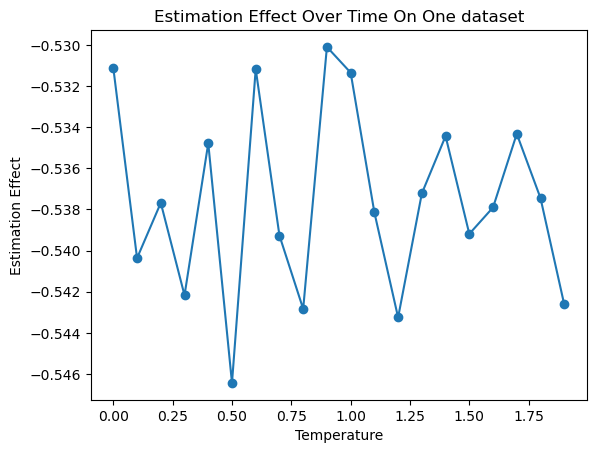

In [ ]:
import matplotlib.pyplot as plt

# 多个dataset再进行estimation
plt.plot(
    results_df["control_value"],
    results_df["estimation_effect"],
    marker="o",
    linestyle="-",
)

plt.title("Estimation Effect Over Temperature On One dataset - Problem Of Overfitting")
plt.xlabel("Temperature")
plt.ylabel("Estimation Effect")
plt.show()

In [ ]:
res_random = model.refute_estimate(
    identified_estimand,
    dml_estimate,
    method_name="random_common_cause",
    show_progress_bar=True,
)
print(res_random)


res_placebo = model.refute_estimate(
    identified_estimand,
    dml_estimate,
    method_name="placebo_treatment_refuter",
    show_progress_bar=True,
    placebo_type="permute",
)


print(res_random)

Refuting Estimates:   0%|          | 0/100 [00:00<?, ?it/s]A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Refuting Estimates:   1%|          | 1/100 [00:00<00:25,  3.82it/s]A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Refuting Estimates:   2%|▏         | 2/100 [00:00<00:22,  4.37it/s]A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Refuting 

Refute: Add a random common cause
Estimated effect:-0.5380224444357403
New effect:-0.5318980649928892
p value:0.6599999999999999



Refuting Estimates:   0%|          | 0/100 [00:00<?, ?it/s]A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Refuting Estimates:   1%|          | 1/100 [00:00<00:11,  8.53it/s]A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Refuting Estimates:   2%|▏         | 2/100 [00:00<00:11,  8.83it/s]A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Refuting 

Refute: Add a random common cause
Estimated effect:-0.5380224444357403
New effect:-0.5318980649928892
p value:0.6599999999999999



In [ ]:
res_placebo.new_effect

res_placebo.estimated_effect

In [ ]:
res_random.refutation_result

{'p_value': 0.6599999999999999, 'is_statistically_significant': False}

In [ ]:
res_placebo.estimated_effect

In [ ]:
res_placebo.refutation_result

{'p_value': 0.8799999999999999, 'is_statistically_significant': False}

In [ ]:
res_placebo.add_significance_test_results

<bound method CausalRefutation.add_significance_test_results of <dowhy.causal_refuter.CausalRefutation object at 0x3ef14f5e0>>

In [ ]:
print(dml_estimate.interpret())

Increasing the treatment variable(s) [Temperature] from 0 to [0.1] causes an increase of -0.5380224444357403 in the expected value of the outcome [['spbleu']], over the data distribution/population represented by the dataset.
None


In [ ]:
dml_estimate.test_stat_significance()

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

{'p_value': 0.109}

In [ ]:
dml_estimate.value

In [ ]:
dml_estimate

# Post-hoc Refutation test 